
### 1. Read & clean up data

Datasets is open-source and were taken from https://huggingface.co/datasets/arkodeep/jobdata (english vacancies) and https://www.kaggle.com/datasets/vyacheslavpanteleev1/hhru-it-vacancies-from-20211025-to-20211202 (russian vacancies)


#### 1. Read

We do not need all the data in the tables, so will throw out some (most) of the columns. Also it is good idea to combine datasets


In [14]:
import pandas as pd

data_en = pd.read_csv('vacancies-skills_datasets/jobs_all.csv')
data_ru = pd.read_csv('vacancies-skills_datasets/IT_vacancies_full.csv')

In [15]:
data_en.columns

Index(['job_title_short', 'job_title', 'job_location', 'job_via',
       'job_schedule_type', 'job_work_from_home', 'search_location',
       'job_posted_date', 'job_no_degree_mention', 'job_health_insurance',
       'job_country', 'salary_rate', 'salary_year_avg', 'salary_hour_avg',
       'company_name', 'job_skills', 'job_type_skills', 'key_id'],
      dtype='object')

In [16]:
data_ru.columns

Index(['Ids', 'Employer', 'Name', 'Salary', 'From', 'To', 'Experience',
       'Schedule', 'Keys', 'Description', 'Area', 'Professional roles',
       'Specializations', 'Profarea names', 'Published at'],
      dtype='object')

In [17]:
data_en = data_en[['job_title','job_skills']]
data_ru = data_ru[['Name','Keys']]

In [18]:
data_en.head()

,job_title,job_skills
0,Senior Clinical Data Engineer / Principal Clin...,NaN
1,Data Analyst,"['r', 'python', 'sql', 'nosql', 'power bi', 't..."
2,"Data Engineer/Scientist/Analyst, Mid or Senior...","['python', 'sql', 'c#', 'azure', 'airflow', 'd..."
3,LEAD ENGINEER - PRINCIPAL ANALYST - PRINCIPAL ...,"['python', 'c++', 'java', 'matlab', 'aws', 'te..."
4,Data Engineer- Sr Jobs,"['bash', 'python', 'oracle', 'aws', 'ansible',..."


In [19]:
data_ru.head()

,Name,Keys
0,Golang Developer (Кипр),"['Docker', 'Golang', 'Redis', 'Английский язык..."
1,Е-mail маркетолог,"['Грамотность', 'Написание текстов', 'Грамотна..."
2,Оператор call-центра (удаленно),"['Клиентоориентированность', 'Ориентация на ре..."
3,Ведущий SMM специалист,"['Продвижение бренда', 'Креативность', 'Adobe ..."
4,UX/UI Designer,"['UI', 'UX', 'gamedev', 'game design', 'проект..."


In [20]:
data_ru.rename(columns = {'Name': 'job_title', 'Keys': 'job_skills'}, inplace = True)

data_combined = pd.concat([data_en, data_ru], ignore_index=True)
data_combined.head()

,job_title,job_skills
0,Senior Clinical Data Engineer / Principal Clin...,NaN
1,Data Analyst,"['r', 'python', 'sql', 'nosql', 'power bi', 't..."
2,"Data Engineer/Scientist/Analyst, Mid or Senior...","['python', 'sql', 'c#', 'azure', 'airflow', 'd..."
3,LEAD ENGINEER - PRINCIPAL ANALYST - PRINCIPAL ...,"['python', 'c++', 'java', 'matlab', 'aws', 'te..."
4,Data Engineer- Sr Jobs,"['bash', 'python', 'oracle', 'aws', 'ansible',..."



#### 2. Clean up text

Transfer everything to the lower register, remove Nans and excess punctiation, convert skills into arrays etc

In [21]:
import re
import ast

data_combined = data_combined.dropna()
data_combined['job_skills'] = data_combined['job_skills'].apply(ast.literal_eval)

def clean_text(text):
    text = text.lower()
    text = re.sub(r'[-/()]', ' ', text)
    text = re.sub(r'[^a-zA-Zа-яА-Я0-9+#+.]', ' ', text)
    text = re.sub(r'\b\d+\b', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

def clean_cell(cell):
    if isinstance(cell, list):
        return [clean_text(item) for item in cell if isinstance(item, str)]
    elif isinstance(cell, str):
        return clean_text(cell)
    else:
        return cell

for col in data_combined.columns:
    data_combined[col] = data_combined[col].apply(clean_cell)


In [22]:
data_combined.head(10)

,job_title,job_skills
1,data analyst,"[r, python, sql, nosql, power bi, tableau]"
2,data engineer scientist analyst mid or senior ...,"[python, sql, c#, azure, airflow, dax, docker,..."
3,lead engineer principal analyst principal engi...,"[python, c++, java, matlab, aws, tensorflow, k..."
4,data engineer sr jobs,"[bash, python, oracle, aws, ansible, puppet, j..."
5,gcp data engineer,"[python, sql, gcp]"
6,senior data engineer gcp cloud,"[sql, python, java, sql server, gcp, bigquery,..."
7,data engineer,"[sql, nosql, gcp, azure, aws, bigquery, databr..."
8,technology operations business analyst,"[excel, powerpoint, power bi]"
9,data scientist ii,"[sql, python, r, mongodb, mongodb, sql server,..."
10,erfahrene r data engineer in m w d,"[python, databricks, azure, spark]"



### 3. Work with job titles
Plan is follows:
1. Remove stop-words
2. Start combining by using n-grams. They help to match patterns like 'pyhon developer' and 'developer python'
3. Create embeddings using sentence transformers or tf-idf
4. Apply clusterization to embeddings using dbscan or hdbscan or agglomerative clustering

#### 3.1 No stop words

In [23]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

stop_words_en = set(stopwords.words('english'))
stop_words_ru = set(stopwords.words('russian'))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [24]:
def remove_stopwords(text):
    words = text.lower().split()
    filtered_words = [w for w in words if w not in stop_words_en and w not in stop_words_ru]
    return filtered_words

In [25]:
sentences = data_combined['job_title'].apply(remove_stopwords).tolist()

print(sentences[:10])
print(sentences[-10:])

[['data', 'analyst'], ['data', 'engineer', 'scientist', 'analyst', 'mid', 'senior', 'f', 'x'], ['lead', 'engineer', 'principal', 'analyst', 'principal', 'engineer', 'data...'], ['data', 'engineer', 'sr', 'jobs'], ['gcp', 'data', 'engineer'], ['senior', 'data', 'engineer', 'gcp', 'cloud'], ['data', 'engineer'], ['technology', 'operations', 'business', 'analyst'], ['data', 'scientist', 'ii'], ['erfahrene', 'r', 'data', 'engineer', 'w']]
[['администратор', 'баз', 'данных', 'database', 'administrator'], ['lead', 'data', 'scientist'], ['инженер', 'категории'], ['специалист', 'поддержки', 'приложений'], ['системный', 'аналитик', 'dwh'], ['монтажник', 'слаботочных', 'систем'], ['системный', 'администратор'], ['менеджер', 'работе', 'маркетплейсами', 'офис'], ['менеджер', 'продажам', 'серверное', 'оборудование', 'b2b'], ['product', 'analyst']]


#### 3.2 N-gramms

* gensim - not cool
* Scikit-learn CountVectorizer - applied
* RAKE / TextRank / YAKE (Unsupervised Keyword Extractors) - not tried

##### gensim

In [26]:
# from gensim.models import Phrases
# from gensim.models.phrases import Phraser

In [27]:
# # create bi-gram model
# bigram_model = Phrases(sentences, min_count=2, threshold=1)
# # min_count=50 — ignore pairs that apper <= 50 times
# # threshold=10 — less phrazes
#
# bigram_model.add_vocab(sentences)
#
#
# bigram_phraser = Phraser(bigram_model)  # to fasten up


In [28]:
# data_combined['job_title_bigram'] = [bigram_phraser[sentence] for sentence in sentences]
#
# print(len(bigram_phraser.phrasegrams))
# print(list(bigram_phraser.phrasegrams)[:20])  # первые 20 биграмм


In [29]:
# data_combined.head(20)

##### count vectorizer

In [30]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(ngram_range=(2, 2), min_df=3)

In [31]:
texts = [' '.join(tokens) for tokens in sentences]
# text -> frequency matrix
X = vectorizer.fit_transform(texts)

# get bigrams and frequences
bigrams = vectorizer.get_feature_names_out()
counts = X.sum(axis=0).A1

# to see
bigrams = vectorizer.get_feature_names_out()
bigram_freq = pd.DataFrame({'bigram': bigrams, 'count': counts})
bigram_freq = bigram_freq.sort_values(by='count', ascending=False)
print(bigram_freq.head(20))


                      bigram   count
10337          data engineer  182609
10106           data analyst  144815
10740         data scientist  137974
35841            senior data   70995
10732           data science   21799
36950      software engineer   15301
23428              lead data   15266
10118         data analytics   12603
24403       machine learning   11211
37743                sr data   11123
6494                big data   10615
6909        business analyst    9563
14128          engineer data    9115
6965   business intelligence    8519
22738            junior data    7911
10341       data engineering    7783
5714              azure data    7314
2004            analyst data    6490
23760      learning engineer    6483
6934           business data    6159


In [32]:
print(bigram_freq.head(20))

                      bigram   count
10337          data engineer  182609
10106           data analyst  144815
10740         data scientist  137974
35841            senior data   70995
10732           data science   21799
36950      software engineer   15301
23428              lead data   15266
10118         data analytics   12603
24403       machine learning   11211
37743                sr data   11123
6494                big data   10615
6909        business analyst    9563
14128          engineer data    9115
6965   business intelligence    8519
22738            junior data    7911
10341       data engineering    7783
5714              azure data    7314
2004            analyst data    6490
23760      learning engineer    6483
6934           business data    6159


In [33]:
def normalize_bigram_str(bigram):
    words = bigram.split()
    if len(words) == 2:
        return " ".join(sorted(words))
    return bigram

bigram_freq['bigram_normalized'] = bigram_freq['bigram'].apply(normalize_bigram_str)

bigram_freq_norm = bigram_freq.groupby('bigram_normalized', as_index=False)['count'].sum()
bigram_freq_norm = bigram_freq_norm.sort_values(by='count', ascending=False)

print(bigram_freq_norm.head(100))

       bigram_normalized   count
15655      data engineer  191724
3141        analyst data  151305
17061     data scientist  140094
17102        data senior   71258
17052       data science   22392
...                  ...     ...
12467      clinical data    1398
31509  machine scientist    1395
7262    associate senior    1393
3325    analyst engineer    1379
15973          data head    1368

[100 rows x 2 columns]


In [34]:
if 'job_title_bigram' in data_combined.columns:
    data_combined.drop(columns=['job_title_bigram'], inplace=True)

data_combined.head()

,job_title,job_skills
1,data analyst,"[r, python, sql, nosql, power bi, tableau]"
2,data engineer scientist analyst mid or senior ...,"[python, sql, c#, azure, airflow, dax, docker,..."
3,lead engineer principal analyst principal engi...,"[python, c++, java, matlab, aws, tensorflow, k..."
4,data engineer sr jobs,"[bash, python, oracle, aws, ansible, puppet, j..."
5,gcp data engineer,"[python, sql, gcp]"


In [35]:
top_bigrams_set = set(bigram_freq['bigram_normalized'])

def extract_normalized_bigrams(text):
    words = re.findall(r'\w+', text.lower())
    pairs = set()
    for i in range(len(words) - 1):
        bigram = " ".join(sorted([words[i], words[i+1]]))
        if bigram in top_bigrams_set:
            pairs.add(bigram)
    return list(pairs)

data_combined['normalized_bigrams'] = data_combined['job_title'].apply(extract_normalized_bigrams)

In [36]:
data_combined.head()

,job_title,job_skills,normalized_bigrams
1,data analyst,"[r, python, sql, nosql, power bi, tableau]",[analyst data]
2,data engineer scientist analyst mid or senior ...,"[python, sql, c#, azure, airflow, dax, docker,...","[analyst mid, data engineer, analyst scientist..."
3,lead engineer principal analyst principal engi...,"[python, c++, java, matlab, aws, tensorflow, k...","[analyst principal, engineer principal, data e..."
4,data engineer sr jobs,"[bash, python, oracle, aws, ansible, puppet, j...","[engineer sr, jobs sr, data engineer]"
5,gcp data engineer,"[python, sql, gcp]","[data engineer, data gcp]"


#### 3.3 Embeddings

Since we already get bigrams, better to use TF-IDF instead of SentenceTransformers. Also they are computationaly cheaper

In [37]:
data_combined.head()

,job_title,job_skills,normalized_bigrams
1,data analyst,"[r, python, sql, nosql, power bi, tableau]",[analyst data]
2,data engineer scientist analyst mid or senior ...,"[python, sql, c#, azure, airflow, dax, docker,...","[analyst mid, data engineer, analyst scientist..."
3,lead engineer principal analyst principal engi...,"[python, c++, java, matlab, aws, tensorflow, k...","[analyst principal, engineer principal, data e..."
4,data engineer sr jobs,"[bash, python, oracle, aws, ansible, puppet, j...","[engineer sr, jobs sr, data engineer]"
5,gcp data engineer,"[python, sql, gcp]","[data engineer, data gcp]"


In [38]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [39]:
bigrams_joined = data_combined['normalized_bigrams'].apply(lambda x: ' '.join(x))

vectorizer = TfidfVectorizer(ngram_range=(1, 2), max_features=5000)
X_tfidf = vectorizer.fit_transform(bigrams_joined)

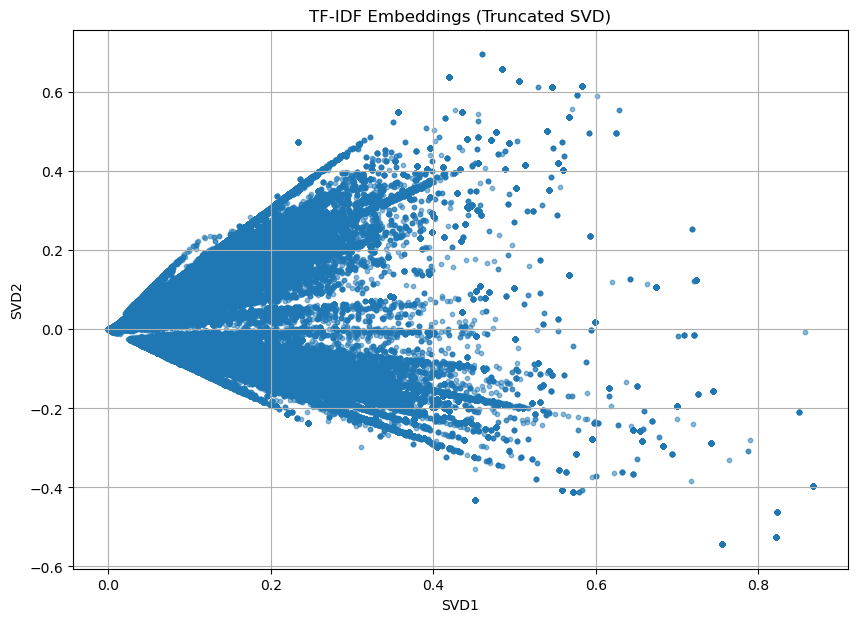

In [40]:
from sklearn.decomposition import TruncatedSVD
import matplotlib.pyplot as plt

svd_plot = TruncatedSVD(n_components=2, random_state=42)
X_svd = svd_plot.fit_transform(X_tfidf)

plt.figure(figsize=(10, 7))
plt.scatter(X_svd[:, 0], X_svd[:, 1], alpha=0.5, s=10)
plt.title("TF-IDF Embeddings (Truncated SVD)")
plt.xlabel("SVD1")
plt.ylabel("SVD2")
plt.grid(True)
plt.show()


X_TFIDF has a size (717268, 5000) - this is 3.5 billion elements (if in DENSE format).

After TRUNCATEDSVD (n_components = 100), the size will become (717268, 100) - many times smaller!

In [41]:
from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD(n_components=100, random_state=42)
X_reduced = svd.fit_transform(X_tfidf)


In [42]:
X_reduced.shape

(717268, 100)

In [45]:
import numpy as np
np.save('X_reduced.npy', X_reduced)

#### 3.4 clusterization
Will use combination of k-means and birch


Firstly, create small sample to calibrate params

In [31]:
import numpy as np

np.random.seed(42)

# create small sample for param calibration
sample_size = int(0.05 * len(X_reduced))
sample_idx = np.random.choice(len(X_reduced), size=sample_size, replace=False)
X_sample = X_reduced[sample_idx]

Now choose the best params

Chhose optimal cluster number:
n_clusters=10: Silhouette score = 0.301
n_clusters=15: Silhouette score = 0.328
n_clusters=20: Silhouette score = 0.351
n_clusters=25: Silhouette score = 0.384
n_clusters=30: Silhouette score = 0.391
n_clusters=35: Silhouette score = 0.407
n_clusters=40: Silhouette score = 0.419
n_clusters=45: Silhouette score = 0.416
n_clusters=50: Silhouette score = 0.411


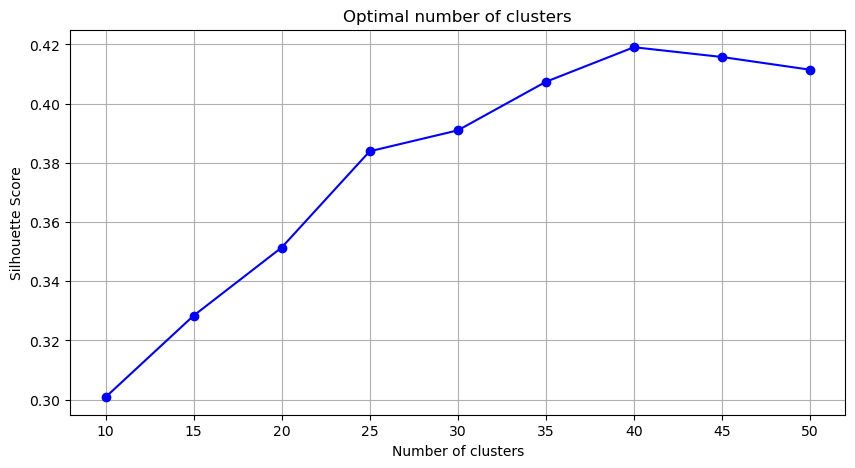


Best result: n_clusters=40 (score=0.419)


In [35]:
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

scores = []
cluster_range = range(10, 51, 5)

print("Chhose optimal cluster number:")
for n in cluster_range:
    kmeans = KMeans(n_clusters=n, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_sample)
    score = silhouette_score(X_sample, labels)
    scores.append(score)
    print(f"n_clusters={n}: Silhouette score = {score:.3f}")

plt.figure(figsize=(10, 5))
plt.plot(cluster_range, scores, 'bo-')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.title('Optimal number of clusters')
plt.grid(True)
plt.show()

best_n = cluster_range[np.argmax(scores)]
best_score = max(scores)
print(f"\nBest result: n_clusters={best_n} (score={best_score:.3f})")


In [38]:
final_kmeans = KMeans(n_clusters=best_n, random_state=42, n_init=10)
sample_labels = final_kmeans.fit_predict(X_sample)

sample_data = data_combined.iloc[sample_idx].copy()
sample_data['cluster'] = sample_labels

print("\nCluster examples:")
for cluster in sorted(sample_data['cluster'].unique()):
    cluster_jobs = sample_data[sample_data['cluster'] == cluster]['job_title'].values
    cluster_skills = sample_data[sample_data['cluster'] == cluster]['job_skills'].explode().value_counts().head(5)

    print(f"\nCluster {cluster} (size: {len(cluster_jobs)})")
    print("Typical vacancies:")
    print(np.unique(cluster_jobs)[:3])
    print("Top-5 skills:")
    print(cluster_skills)


Cluster examples:

Cluster 0 (size: 248)
Typical vacancies:
['analyst marketing' 'analyst marketing analytics'
 'analyst marketing innovation']
Top-5 skills:
job_skills
sql         147
tableau     101
excel        99
python       97
power bi     60
Name: count, dtype: int64

Cluster 1 (size: 3876)
Typical vacancies:
['1с analyst consultant' '3m data analyst ii san diego ca'
 '4cs4u data analyst cape cod community college']
Top-5 skills:
job_skills
sql         1962
excel       1742
python      1249
tableau     1041
power bi     842
Name: count, dtype: int64

Cluster 2 (size: 1179)
Typical vacancies:
['analytics senior data engineer' 'architecte data senior'
 'bl senior data engineer']
Top-5 skills:
job_skills
python    872
sql       825
aws       552
azure     459
spark     446
Name: count, dtype: int64

Cluster 3 (size: 2302)
Typical vacancies:
['0501wfh data scientist' 'adot data scientist' 'agile1 data scientist']
Top-5 skills:
job_skills
python     1934
sql        1334
r          1

In [36]:
final_kmeans = KMeans(n_clusters=best_n, random_state=42)
data_combined['cluster'] = final_kmeans.fit_predict(X_reduced)

In [37]:
data_combined.head(10)

,job_title,job_skills,normalized_bigrams,cluster
1,data analyst,"[r, python, sql, nosql, power bi, tableau]",[analyst data],4
2,data engineer scientist analyst mid or senior ...,"[python, sql, c#, azure, airflow, dax, docker,...","[data engineer, analyst mid, engineer scientis...",10
3,lead engineer principal analyst principal engi...,"[python, c++, java, matlab, aws, tensorflow, k...","[data engineer, analyst principal, engineer le...",14
4,data engineer sr jobs,"[bash, python, oracle, aws, ansible, puppet, j...","[data engineer, engineer sr, jobs sr]",11
5,gcp data engineer,"[python, sql, gcp]","[data engineer, data gcp]",15
6,senior data engineer gcp cloud,"[sql, python, java, sql server, gcp, bigquery,...","[data senior, data engineer, cloud gcp, engine...",14
7,data engineer,"[sql, nosql, gcp, azure, aws, bigquery, databr...",[data engineer],3
8,technology operations business analyst,"[excel, powerpoint, power bi]","[operations technology, analyst business, busi...",34
9,data scientist ii,"[sql, python, r, mongodb, mongodb, sql server,...","[data scientist, ii scientist]",10
10,erfahrene r data engineer in m w d,"[python, databricks, azure, spark]",[data engineer],3


In [42]:
# save dataframe
data_combined.to_pickle('clustered_vacancies_full.pkl')


In [119]:
import pandas as pd

try:
    data_clustered = pd.read_pickle('clustered_vacancies_full.pkl')
    print("All data successfully downloaded!")
except FileNotFoundError:
    print("No file exists, please do clusterization again :(")

All data successfully downloaded!


#### 3.5 Post-Clusterizarion

In [120]:
cluster_sizes = data_clustered['cluster'].value_counts()
print(cluster_sizes)

cluster
14    160491
3      61968
19     58324
1      47693
4      46386
10     44853
8      23217
20     18576
0      18434
11     17804
13     15656
15     14850
7      13740
12     11213
9      10546
5       9973
33      9799
37      8445
27      8386
18      8259
31      8103
17      8033
21      7967
24      7719
35      7004
16      6895
2       6203
28      5818
38      5469
6       5239
36      5175
25      5148
29      4551
23      4162
22      4022
34      3906
30      3659
32      3615
26      3353
39      2614
Name: count, dtype: int64


##### Too big clusters

If cluster is too big, there is a need to divide it

In [122]:
large_cluster_threshold = 50000
cluster_sizes = data_clustered['cluster'].value_counts()
big_clusters = cluster_sizes[cluster_sizes > large_cluster_threshold].index

for cluster in big_clusters:
    cluster_data = data_clustered[data_clustered['cluster'] == cluster]
    print(f"\nCluster {cluster} ({len(cluster_data)} records):")
    print("Top-5 vacancies:")
    print(cluster_data['job_title'].value_counts().head(5))
    print("\nTop-10 skills:")
    print(cluster_data['job_skills'].explode().value_counts().head(10))



Cluster 14 (160491 records):
Top-5 vacancies:
job_title
analyst                 884
qa engineer             632
data architect          621
database engineer       551
data quality analyst    498
Name: count, dtype: int64

Top-10 skills:
job_skills
sql         64251
python      53868
excel       27616
aws         23422
azure       21927
tableau     18513
java        17733
spark       15653
power bi    15615
r           14353
Name: count, dtype: int64

Cluster 3 (61968 records):
Top-5 vacancies:
job_title
data engineer          53677
data engineer h f       1389
data engineer m w d      530
data engineer f h        512
data engineer m f d      284
Name: count, dtype: int64

Top-10 skills:
job_skills
sql        44484
python     41611
aws        22598
azure      22576
spark      19599
java       12961
hadoop     10495
kafka      10440
scala      10331
airflow    10273
Name: count, dtype: int64

Cluster 19 (58324 records):
Top-5 vacancies:
job_title
marketing data analyst    970
financial

To identify whether it is worth to divide cluster, let's introduce **diversity** metric

**diversity** = 1 - (frequency of the most popular vacancy / total number of vacancies in a cluster)

* diversity <0.1 → Closure is very homogeneous → Do not divide

* 0.1 ≤ diversity <0.3 → Moderate heterogeneity → Divide optionally

* diversity ≥ 0.3 → Closure is very heterogeneous → It is better to divide

In [123]:
diversity_scores = {}

for cluster in big_clusters:
    titles = data_clustered.loc[data_clustered['cluster'] == cluster, 'job_title']
    most_common = titles.value_counts().iloc[0]
    total = len(titles)
    diversity = 1 - (most_common / total)
    diversity_scores[cluster] = diversity


In [124]:
for cl, score in sorted(diversity_scores.items(), key=lambda x: -x[1]):
    print(f"Cluster {cl}: diversity = {score:.2f}")


Cluster 14: diversity = 0.99
Cluster 19: diversity = 0.98
Cluster 3: diversity = 0.13


In [125]:
# better to not touch it
big_clusters = [c for c in big_clusters if c != 3]

In [126]:
import numpy as np

X_reduced = np.load('X_reduced.npy')

In [127]:
from sklearn.cluster import MiniBatchKMeans

for cluster in big_clusters:
    mask = data_clustered['cluster'] == cluster
    X_cluster = X_reduced[mask]

    if len(X_cluster) < 1000:
        continue

    n_subclusters = max(2, len(X_cluster) // 5000)

    print(f"Cluster {cluster} → divide to {n_subclusters} subclusters")

    kmeans = MiniBatchKMeans(n_clusters=n_subclusters, random_state=42, batch_size=1024)
    sub_labels = kmeans.fit_predict(X_cluster)

    data_clustered.loc[mask, 'cluster'] = sub_labels + (cluster * 100)


Cluster 14 → divide to 32 subclusters
Cluster 19 → divide to 11 subclusters


In [128]:
cluster_sizes = data_clustered['cluster'].value_counts()
print(cluster_sizes)

cluster
3       61968
1       47693
4       46386
10      44853
1422    38333
        ...  
1907     1097
1428     1022
1903      988
1431      835
1427      747
Name: count, Length: 81, dtype: int64


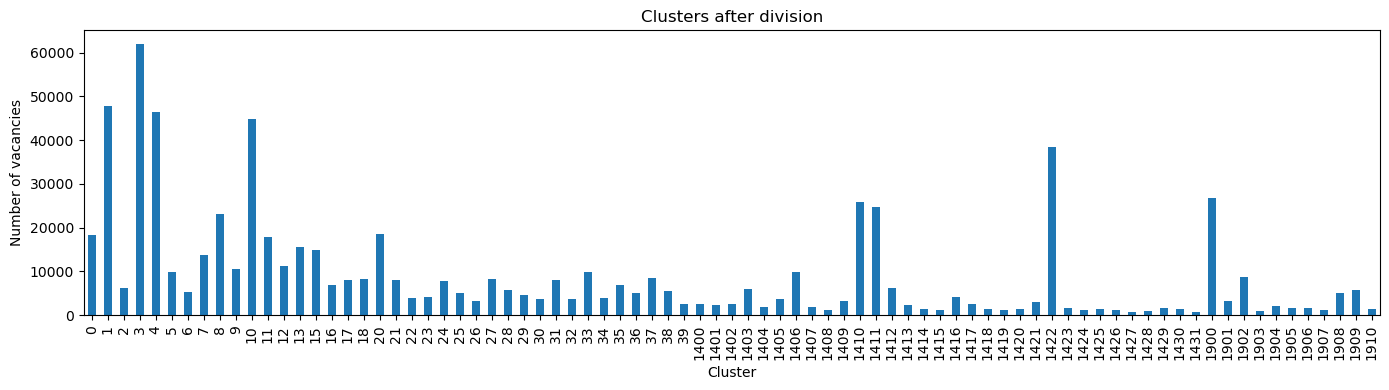

In [129]:
import matplotlib.pyplot as plt
data_clustered['cluster'].value_counts().sort_index().plot(kind='bar', figsize=(14, 4))
plt.title('Clusters after division')
plt.xlabel('Cluster')
plt.ylabel('Number of vacancies')
plt.tight_layout()
plt.show()


##### Too small clusters

In [130]:
cluster_sizes = data_clustered['cluster'].value_counts()
small_clusters = cluster_sizes[cluster_sizes < 2000]
print(small_clusters)


cluster
1404    1887
1407    1840
1429    1693
1423    1690
1905    1565
1906    1564
1420    1464
1910    1463
1430    1347
1418    1330
1425    1318
1414    1310
1426    1244
1419    1238
1408    1224
1415    1221
1424    1209
1907    1097
1428    1022
1903     988
1431     835
1427     747
Name: count, dtype: int64


In [131]:
total_records = len(data_clustered)
small_total = small_clusters.sum()
print(f"Small clusters (<2k): {len(small_clusters)}")
print(f"Total number of entries: {small_total} ({small_total / total_records:.2%} from all)")


Small clusters (<2k): 22
Total number of entries: 29296 (4.08% from all)


In [132]:
small_clusters = cluster_sizes[cluster_sizes < 2000].index

for cluster in small_clusters:
    cluster_data = data_clustered[data_clustered['cluster'] == cluster]

    print(f"\nCluster {cluster} ({len(cluster_data)} records):")
    print("Top-5 vacancies:")
    print(cluster_data['job_title'].value_counts().head(5))

    print("\nTop-10 skills:")
    print(cluster_data['job_skills'].explode().value_counts().head(10))



Cluster 1404 (1887 records):
Top-5 vacancies:
job_title
data architect             621
senior data architect      112
data engineer architect     92
data architect engineer     47
solution architect          29
Name: count, dtype: int64

Top-10 skills:
job_skills
sql           1045
azure          888
python         780
aws            687
spark          497
databricks     364
hadoop         329
kafka          319
java           308
snowflake      305
Name: count, dtype: int64

Cluster 1407 (1840 records):
Top-5 vacancies:
job_title
database engineer           551
senior database engineer    209
database analyst            187
senior database analyst      45
cloud database engineer      27
Name: count, dtype: int64

Top-10 skills:
job_skills
sql           1269
oracle         615
python         488
sql server     487
mongodb        484
postgresql     450
mysql          425
aws            396
azure          313
linux          295
Name: count, dtype: int64

Cluster 1429 (1693 records):
Top

Small clusters 1431 (marketing analyst) and 1428 (sales analyst) share similar skill sets (SQL, Excel, Tableau, Python) and overlapping job roles focused on data analysis in marketing and sales domains. Merging them makes sense to reduce fragmentation without losing meaningful distinctions.

In [133]:
data_clustered.loc[data_clustered['cluster'] == 1428, 'cluster'] = 1431

##### Report abt final clusters

In [46]:
import pandas as pd

cluster_summary = []
for cl in sorted(data_clustered['cluster'].unique()):
    cluster_data = data_clustered[data_clustered['cluster'] == cl]
    size = len(cluster_data)
    top_titles = cluster_data['job_title'].value_counts().head(5).to_dict()
    top_skills = cluster_data['job_skills'].explode().value_counts().head(10).to_dict()
    cluster_summary.append({'cluster': cl, 'size': size, 'top_titles': top_titles, 'top_skills': top_skills})

df_summary = pd.DataFrame(cluster_summary)
df_summary.to_csv('cluster_summary.csv', index=False)


In [115]:
df_summary['cluster'].unique()

array([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,   10,
         11,   12,   13,   15,   16,   17,   18,   20,   21,   22,   23,
         24,   25,   26,   27,   28,   29,   30,   31,   32,   33,   34,
         35,   36,   37,   38,   39, 1400, 1401, 1402, 1403, 1404, 1405,
       1406, 1407, 1408, 1409, 1410, 1411, 1412, 1413, 1414, 1415, 1416,
       1417, 1418, 1419, 1420, 1421, 1422, 1423, 1424, 1425, 1426, 1427,
       1429, 1430, 1431, 1900, 1901, 1902, 1903, 1904, 1905, 1906, 1907,
       1908, 1909, 1910])

In [160]:
print(sorted(data_clustered['cluster'].unique()))

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 15, 16, 17, 18, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 1400, 1401, 1402, 1403, 1404, 1405, 1406, 1407, 1408, 1409, 1410, 1411, 1412, 1413, 1414, 1415, 1416, 1417, 1418, 1419, 1420, 1421, 1422, 1423, 1424, 1425, 1426, 1427, 1429, 1430, 1431, 1900, 1901, 1902, 1903, 1904, 1905, 1906, 1907, 1908, 1909, 1910]


#### Rename clusters into vacancies

##### Problem clusters division


In [172]:
X_reduced.shape

(717268, 100)

In [173]:
#28, 1412

problem_clusters = [28, 1412]
problem_data = data_clustered[data_clustered['cluster'].isin(problem_clusters)].copy()

In [174]:
import pprint
pp = pprint.PrettyPrinter(indent=4, width=100, compact=True)

for cluster in problem_clusters:
    cluster_data = problem_data[problem_data['cluster'] == cluster]

    print(f"\n{'='*50}")
    print(f"=== Analyzis of cluster {cluster} (n={len(cluster_data)}) ===")
    print(f"{'='*50}")

    print("\n📌 vacancies:")
    title_counts = cluster_data['job_title'].value_counts().head(20).to_dict()
    pp.pprint(title_counts)

    print("\n🔧 skills:")
    skills = cluster_data['job_skills'].explode()
    skill_counts = skills.value_counts().head(20).to_dict()
    pp.pprint(skill_counts)


=== Analyzis of cluster 28 (n=5818) ===

📌 vacancies:
{   '.net разработчик': 25,
    'android разработчик': 101,
    'backend разработчик': 42,
    'frontend разработчик': 228,
    'frontend разработчик angular': 28,
    'frontend разработчик react': 42,
    'frontend разработчик vue.js': 26,
    'full stack разработчик': 22,
    'fullstack разработчик': 22,
    'ios разработчик': 116,
    'java разработчик': 245,
    'php разработчик': 106,
    'python разработчик': 66,
    'web разработчик': 55,
    'ведущий разработчик 1с': 27,
    'программист разработчик': 33,
    'разработчик 1с': 60,
    'разработчик android': 22,
    'разработчик java': 25,
    'разработчик python': 43}

🔧 skills:
{   'c#': 364,
    'css': 522,
    'css3': 305,
    'docker': 333,
    'git': 1746,
    'html': 504,
    'html5': 391,
    'java': 976,
    'javascript': 1349,
    'linux': 551,
    'mysql': 585,
    'php': 667,
    'postgresql': 853,
    'python': 521,
    'react': 419,
    'spring framework': 488,

In [175]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score

def find_best_n(X, min_k=2, max_k=10):
    best_score = -1
    best_k = min_k
    for k in range(min_k, min(max_k, len(X))):
        labels = AgglomerativeClustering(n_clusters=k).fit_predict(X)
        if len(set(labels)) < 2:
            continue
        score = silhouette_score(X, labels)
        if score > best_score:
            best_score = score
            best_k = k
    return best_k

for cluster_id in problem_clusters:
    mask = data_clustered['cluster'] == cluster_id
    X_sub = X_reduced[mask]

    best_k = find_best_n(X_sub)
    labels = AgglomerativeClustering(n_clusters=best_k).fit_predict(X_sub)

    offset = cluster_id * 100
    data_clustered.loc[mask, 'cluster'] = labels + offset


C:\Users\user\AppData\Local\Temp\ipykernel_1912\2194355022.py:25: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[2800 2800 2800 ... 2800 2800 2800]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  data_clustered.loc[mask, 'cluster'] = labels + offset


In [176]:
for base_cluster in [28, 1412]:
    print(f"\n===== Subclusters of cluster {base_cluster} =====")

    subclusters = data_clustered[
        data_clustered['cluster'].astype(str).str.startswith(str(base_cluster))
    ]['cluster'].unique()

    for sub in sorted(subclusters):
        sub_data = data_clustered[data_clustered['cluster'] == sub]
        print(f"\n=== Subcluster {sub} (n={len(sub_data)}) ===")
        print("📌 Top vacancies:")
        print(sub_data['job_title'].value_counts().head(5))
        print("\n🔧 Top skills:")
        print(sub_data['job_skills'].explode().value_counts().head(10))



===== Subclusters of cluster 28 =====

=== Subcluster 2800 (n=5008) ===
📌 Top vacancies:
job_title
frontend разработчик    228
ios разработчик         116
php разработчик         106
android разработчик     101
python разработчик       66
Name: count, dtype: int64

🔧 Top skills:
job_skills
git           1488
javascript    1320
sql            912
php            665
postgresql     636
ооп            585
mysql          561
css            514
python         508
html           490
Name: count, dtype: int64

=== Subcluster 2801 (n=810) ===
📌 Top vacancies:
job_title
java разработчик            245
разработчик java             25
ведущий java разработчик     21
senior java разработчик      20
middle java разработчик      18
Name: count, dtype: int64

🔧 Top skills:
job_skills
java                637
spring framework    443
git                 258
sql                 225
postgresql          217
hibernate orm       142
apache maven         99
ооп                  82
kafka                71
rest

In [181]:
from collections import Counter

def split_by_top_bigrams(data, cluster_id, top_n=5, min_size=30):
    cluster_data = data[data['cluster'] == cluster_id].copy()

    all_bigrams = cluster_data['normalized_bigrams'].explode().tolist()
    bigram_counts = Counter(all_bigrams)

    top_bigrams = [bg for bg, _ in bigram_counts.most_common(top_n)]
    print(f"Top {top_n} bigrams for cluster {cluster_id}:", top_bigrams)

    new_labels = pd.Series([-1]*len(cluster_data), index=cluster_data.index)

    subcluster_index = 0
    for bg in top_bigrams:
        mask = cluster_data['normalized_bigrams'].apply(lambda bigrams: bg in bigrams)
        subgroup_indices = cluster_data.index[mask]

        if len(subgroup_indices) < min_size:
            continue

        new_labels.loc[subgroup_indices] = cluster_id * 1000 + subcluster_index
        subcluster_index += 1

    new_labels[new_labels == -1] = cluster_id

    data.loc[new_labels.index, 'cluster'] = new_labels

    return data

data_clustered = split_by_top_bigrams(data_clustered, 2800, top_n=15)
data_clustered = split_by_top_bigrams(data_clustered, 141200, top_n=10)

print(data_clustered['cluster'].value_counts().sort_index())


Top 15 bigrams for cluster 2800: ['go разработчик', 'инженер разработчик', 'javascript разработчик', 'разработчик старший', 'golang разработчик', 'sql разработчик', 'fullstack разработчик', 'end разработчик', 'dwh разработчик', 'etl разработчик', 'end front', 'bi разработчик', 'js разработчик', 'abap разработчик', 'data engineer']
Top 10 bigrams for cluster 141200: ['developer net', 'developer end', 'developer senior', 'developer golang', 'developer scala', 'developer unity', 'backend developer', 'analyst developer', 'end front', 'middle senior']
cluster
0            18434
1            47693
2             6203
3            61968
4            46386
             ...  
141200005      327
141200006      323
141200007      300
141200008      285
141200009      264
Name: count, Length: 108, dtype: int64


##### Back to renaming

In [183]:
cluster_names = {
    #ds & ml
    1: 'data scientist',
    0: 'lead data scientist',

    9: 'machine learning engineer',
    1430: 'machine learning engineer',

    10:'middle data scientist',
    13: 'senior data scientist',
    15: 'junior data scientist',
    33: 'junior data scientist',
    # data engineering
    11: 'data engineer',
    1400: 'data engineer',
    1406: 'consulting data engineer',
    3: 'junior data engineer',
    8: 'senior data engineer',
    1427: 'senior data engineer',
    1416: 'middle data engineer',
    12: 'lead data engineer',
    27: 'lead data engineer',

    1418: 'associate data engineer',

    16: 'azure data engineer',
    31: 'big data engineer',
    30: 'aws data engineer',
    1426: 'data warehouse engineer',

    # data analyzis
    4: 'data analyst',
    1909: 'data analyst',
    1903: 'data analyst',
    1907: 'data analyst',
    1422: 'data analyst',
    1429: 'data analyst',
    1404: 'data architect',
    20: 'data analyst',
    18: 'data analyst',
    5: 'senior data analyst',
    26: 'senior data analyst',
    24: 'senior data analyst',
    1910: 'senior data analyst',
    1423: 'middle data analyst',
    1905: 'junior data analyst',

    1425: 'digital analyst',

    1405: 'data manager',
    1417: 'data manager',

    1419: 'data integration specialist',

    6: 'business data analyst',
    17: 'business data analyst',
    21: 'bi analyst',
    34: 'business data analyst',
    37: 'business data analyst',
    1415: 'business data analyst',
    36: 'system data analyst',
    1410: 'business data analyst',

    23: 'research analyst',
    29: 'technical writer',

    28: 'product analyst',
    38: 'product analyst',
    1424: 'data visualization',

    1902: 'clinical data analyst',
    1906: 'clinical data analyst',
    1908: 'clinical data analyst',

    1904: 'financial data analyst',
    1431: 'marketing data analyst',
    1900: 'marketing data analyst',
    1901: 'marketing data analyst',

    39: 'sap data analyst',

    # soft and devops
    1401:'qa engineer',
    1402:'qa engineer',
    7: 'software developer',
    22: 'data platform engineer',
    32: 'devops engineer',

    35: 'python developer',

    1403: 'technical support',
    1413: 'technical support',
    1421: 'technical support',


    1411: 'mlops dataops',

    1420: 'backend developer',

    1414: 'fullstack developer',

    2: 'cloud data engineer',

    25: 'principal data engineer',

    1407: 'database engineer',
    1408: 'governance data engineer',

}

In [184]:
all_clusters = set(data_clustered['cluster'].unique())
named_clusters = set(cluster_names.keys())
print(all_clusters)
print(len(all_clusters))
clusters_without_names = all_clusters - named_clusters
print("Clusters without names:", clusters_without_names)

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 15, 16, 17, 18, 2800009, 20, 21, 22, 23, 24, 25, 26, 27, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 2800010, 2800011, 2800012, 2800013, 141200000, 141200001, 141200002, 141200003, 141200004, 141200005, 141200006, 141200007, 141200008, 141200009, 2800, 2801, 2800000, 2800002, 2800003, 2800004, 2800005, 2800006, 1900, 1901, 1902, 1903, 1904, 1905, 1906, 1907, 1908, 1909, 1910, 2800007, 1400, 1401, 1402, 1403, 1404, 1405, 1406, 1407, 1408, 1409, 1410, 1411, 2800001, 1413, 1414, 1415, 1416, 1417, 1418, 1419, 1420, 1421, 1422, 1423, 141200, 1425, 1424, 1427, 141202, 1429, 1430, 1431, 1426, 141201, 2800014, 2800008}
108
Clusters without names: {141200000, 141200001, 141200002, 141200003, 141200004, 141200005, 141200006, 141200007, 141200008, 2800009, 2800010, 2800011, 2800012, 2800013, 141200009, 2800006, 2800007, 141200, 141202, 141201, 2800014, 1409, 2800000, 2800001, 2800002, 2800003, 2800004, 2800005, 2800, 2801, 2800008}


In [185]:
for cl in clusters_without_names:
    cluster_data = data_clustered[data_clustered['cluster'] == cl]
    print(f"\nCluster {cl} (n={len(cluster_data)})")

    print("Top-10 vacancies:")
    print(cluster_data['job_title'].value_counts().head(10))

    print("\nTop-10 skills:")
    print(cluster_data['job_skills'].explode().value_counts().head(10))


Cluster 141200000 (n=714)
Top-10 vacancies:
job_title
data developer                                                            178
.net developer                                                             39
entry level programmer coder developer data scientist analyst engineer     34
data developer engineer                                                    15
senior .net developer                                                      14
telecommute senior data developer                                          14
junior level programmer coder developer data...                            13
it data developer                                                          12
data developer analyst                                                     11
sql data developer                                                          6
Name: count, dtype: int64

Top-10 skills:
job_skills
sql           376
python        295
java          169
spark         136
c#            131
aws           130
azur

In [210]:
cluster_names.update({
    141200000: "data engineer",
    141200001: "frontend developer",
    141200002: "software developer",
    141200003: "golang data engineer",
    141200004: "tableau developer",
    141200005: "php developer",
    141200006: "android developer",
    141200007: "data analyst",
    141200008: "ios developer",
    2800009: "frontend developer",
    2800010: "web developer",
    2800011: "backend developer",
    # 2800012: "Database Engineer", #noisy
    2800013: ".net developer",
    141200009: "frontend developer",
    2800006: 'python developer',
    2800007: 'backend developer',
    # 141200: '' #noisy
    141202: 'etl developer',
    141201: 'java developer',
    2800014: 'fullstack developer',
    # 1409: '' #non eng
    2800000: 'frontend developer',
    2800001: 'php developer',
    2800002: 'ios developer',
    2800003: 'android developer',
    2800004: '1c developer',
    # 2800005: '' #noisy
    # 2800: ''
    2801: 'java developer',
    2800008: '1c developer'
})

In [211]:
print(cluster_names)
print('num clusters', len(cluster_names))
print('names for clusters', len(set(cluster_names.values())))

{1: 'data scientist', 0: 'lead data scientist', 9: 'machine learning engineer', 1430: 'machine learning engineer', 10: 'middle data scientist', 13: 'senior data scientist', 15: 'junior data scientist', 33: 'junior data scientist', 11: 'data engineer', 1400: 'data engineer', 1406: 'consulting data engineer', 3: 'junior data engineer', 8: 'senior data engineer', 1427: 'senior data engineer', 1416: 'middle data engineer', 12: 'lead data engineer', 27: 'lead data engineer', 1418: 'associate data engineer', 16: 'azure data engineer', 31: 'big data engineer', 30: 'aws data engineer', 1426: 'data warehouse engineer', 4: 'data analyst', 1909: 'data analyst', 1903: 'data analyst', 1907: 'data analyst', 1422: 'data analyst', 1429: 'data analyst', 1404: 'data architect', 20: 'data analyst', 18: 'data analyst', 5: 'senior data analyst', 26: 'senior data analyst', 24: 'senior data analyst', 1910: 'senior data analyst', 1423: 'middle data analyst', 1905: 'junior data analyst', 1425: 'digital analyst

In [212]:
print(all_clusters)
print('overall clusters: ', len(all_clusters))

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 15, 16, 17, 18, 2800009, 20, 21, 22, 23, 24, 25, 26, 27, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 2800010, 2800011, 2800012, 2800013, 141200000, 141200001, 141200002, 141200003, 141200004, 141200005, 141200006, 141200007, 141200008, 141200009, 2800, 2801, 2800000, 2800002, 2800003, 2800004, 2800005, 2800006, 1900, 1901, 1902, 1903, 1904, 1905, 1906, 1907, 1908, 1909, 1910, 2800007, 1400, 1401, 1402, 1403, 1404, 1405, 1406, 1407, 1408, 1409, 1410, 1411, 2800001, 1413, 1414, 1415, 1416, 1417, 1418, 1419, 1420, 1421, 1422, 1423, 141200, 1425, 1424, 1427, 141202, 1429, 1430, 1431, 1426, 141201, 2800014, 2800008}
overall clusters:  108


In [213]:
print([i for i in cluster_names if i not in all_clusters])

[28, 141200011, 141200012, 141200013, 141200014, 141200010]


In [214]:
data_clustered['cluster_name'] = data_clustered['cluster'].map(cluster_names).fillna('Other')
data_clustered.head()

,job_title,job_skills,normalized_bigrams,cluster,cluster_name
1,data analyst,"[r, python, sql, nosql, power bi, tableau]",[analyst data],4,data analyst
2,data engineer scientist analyst mid or senior ...,"[python, sql, c#, azure, airflow, dax, docker,...","[data engineer, analyst mid, engineer scientis...",10,middle data scientist
3,lead engineer principal analyst principal engi...,"[python, c++, java, matlab, aws, tensorflow, k...","[data engineer, analyst principal, engineer le...",1406,consulting data engineer
4,data engineer sr jobs,"[bash, python, oracle, aws, ansible, puppet, j...","[data engineer, engineer sr, jobs sr]",11,data engineer
5,gcp data engineer,"[python, sql, gcp]","[data engineer, data gcp]",15,junior data scientist


In [215]:
len(set(data_clustered['cluster_name'].unique()))
print([i for i in set(cluster_names.values()) if i not in data_clustered['cluster_name'].unique()])

[]



### 4. Work with job clusters and skills


In [201]:
data_clustered['cluster'].unique()

array([        4,        10,      1406,        11,        15,      1416,
               3,        34,      1908,         8,        31,         0,
               1,      1900,        26,      1408,        35,      1407,
               5,      1410,        27,      1402,        23,        20,
              13,        17,      1414,        21,      1422,         7,
              25,        37,        18,        32,         9,        29,
              12,         2,        30,      1411,        33,        16,
            1427,      1425,      1404,      1903,      1901,      1400,
            1413,        38,      1909,      1401,      1409,        24,
       141200002,      1431,      1902,      1418,      1417,         6,
              22,      1905,      1405,      1429,      1424,    141200,
       141200000,      1907,        39,      1906,      1430,      1423,
            1910,      1403,      1904,      1420,      1421,      1419,
          141202,      1426,      1415,        36, 

In [217]:
filtered = data_clustered[data_clustered['cluster_name'] != 'Other'].copy()
cluster_stats = []

for cluster_name, group in filtered.groupby('cluster_name'):
    all_skills = group['job_skills'].explode()
    skill_counts = Counter(all_skills)
    cluster_stats.append({
        'cluster_name': cluster_name,
        'n_rows': len(group),
        'n_unique_skills': len(skill_counts),
        'skill_counts': dict(skill_counts.most_common())
    })

cluster_stats_df = pd.DataFrame(cluster_stats)

In [218]:
print((cluster_stats_df['cluster_name']))

0                  .net developer
1                    1c developer
2               android developer
3         associate data engineer
4               aws data engineer
5             azure data engineer
6               backend developer
7                      bi analyst
8               big data engineer
9           business data analyst
10          clinical data analyst
11            cloud data engineer
12       consulting data engineer
13                   data analyst
14                 data architect
15                  data engineer
16    data integration specialist
17                   data manager
18         data platform engineer
19                 data scientist
20             data visualization
21        data warehouse engineer
22              database engineer
23                devops engineer
24                digital analyst
25                  etl developer
26         financial data analyst
27             frontend developer
28            fullstack developer
29           g

In [219]:
cluster_stats_df.to_csv('cluster_stats.csv', index=False)
cluster_stats_df

,cluster_name,n_rows,n_unique_skills,skill_counts
0,.net developer,464,539,"{'c#': 127, 'sql': 125, '.net framework': 81, ..."
1,1c developer,492,588,"{'1с программирование': 133, 'sql': 111, '1с п..."
2,android developer,635,509,"{'kotlin': 352, 'android': 336, 'java': 291, '..."
3,associate data engineer,1330,154,"{'sql': 808, 'python': 766, 'aws': 361, 'azure..."
4,aws data engineer,3659,179,"{'aws': 3563, 'python': 2608, 'sql': 2161, 're..."
5,azure data engineer,6895,168,"{'azure': 6810, 'sql': 5125, 'databricks': 373..."
6,backend developer,1862,705,"{'python': 731, 'aws': 619, 'sql': 590, 'docke..."
7,bi analyst,7967,349,"{'sql': 5785, 'power bi': 4727, 'python': 2469..."
8,big data engineer,9546,843,"{'spark': 5403, 'python': 5197, 'sql': 4846, '..."
9,business data analyst,52803,598,"{'sql': 27833, 'excel': 23316, 'python': 14739..."


In [38]:
import pandas as pd

data_skills = pd.read_csv('cluster_stats.csv')

In [39]:
import ast
# data_skills = data_skills.drop('n_rows', axis=1)

def safe_literal_eval(s):
    try:
        return ast.literal_eval(s)
    except Exception as e:
        print("Error parsing:", s)
        raise e

data_skills['skill_counts'] = data_skills['skill_counts'].str.replace(r'nan:\s*\d*,?', '', regex=True).str.strip(', ')
data_skills['skill_counts'] = data_skills['skill_counts'].apply(safe_literal_eval)

In [40]:
data_skills.head()

,cluster_name,n_rows,n_unique_skills,skill_counts
0,.net developer,464,539,"{'c#': 127, 'sql': 125, '.net framework': 81, ..."
1,1c developer,492,588,"{'1с программирование': 133, 'sql': 111, '1с п..."
2,android developer,635,509,"{'kotlin': 352, 'android': 336, 'java': 291, '..."
3,associate data engineer,1330,154,"{'sql': 808, 'python': 766, 'aws': 361, 'azure..."
4,aws data engineer,3659,179,"{'aws': 3563, 'python': 2608, 'sql': 2161, 're..."


##### Plan

| Step                         | Description                                                 |
|------------------------------| ----------------------------------------------------------- |
| **1. Prepare data**          | Build a table of raw skill frequencies per profession       |
| **2. TF-IDF**                | Scores skills by how specific they are to each profession   |
| **3. Core skill filtering**  | Keeps skills that occur in ≥ 40% of jobs in that profession |
| **4. Merge TF-IDF and Core** | Keeps only skills that are both important and frequent      |
| **5. Apriori**               | Finds common combinations of core skills across professions |



##### 1. Prepare data


In [41]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfTransformer

In [42]:

# Create raw count matrix
all_skills = set()
for row in data_skills['skill_counts']:
    all_skills.update(row.keys())

all_skills = sorted(all_skills)

# Build skill frequency table (cluster x skill)
skill_matrix = pd.DataFrame(0, index=data_skills['cluster_name'], columns=all_skills)

for i, row in data_skills.iterrows():
    for skill, count in row['skill_counts'].items():
        skill_matrix.loc[row['cluster_name'], skill] = count

In [43]:
skill_matrix.head()

,,.,.net,.net .,.net core,.net core +,.net core .,.net core standard .+,.net framework,.net framework .,...,яндекс метрика,яндекс эксперименты,яндекс.вебмастер,яндекс.директ,яндекс.маркет,яндекс.метрика,янино,янтарь,яп,японский язык
cluster_name,,,,,,,,,,,,,,,,,,,,,
.net developer,0,0,10,0,29,0,1,0,81,0,...,0,0,0,0,0,0,0,0,0,0
1c developer,0,1,1,0,3,0,0,0,12,0,...,0,0,0,0,0,0,0,0,0,0
android developer,0,0,1,0,5,0,0,0,15,0,...,0,0,0,0,0,0,0,0,0,0
associate data engineer,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
aws data engineer,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [44]:
skill_matrix = skill_matrix.fillna(0)
skill_matrix = skill_matrix.loc[:, skill_matrix.sum(axis=0) > 0]

In [45]:
import string

def is_pure_punct_or_empty(s):
    if not isinstance(s, str):
        return True
    s = s.strip()
    if s == '':
        return True
    return all(ch in string.punctuation for ch in s)

cols = [col for col in skill_matrix.columns if not is_pure_punct_or_empty(col)]
skill_matrix = skill_matrix[cols]


In [46]:
skill_matrix.shape

(60, 12574)


##### 2. TF-IDF


In [47]:
tfidf = TfidfTransformer()
tfidf_m = pd.DataFrame(
    tfidf.fit_transform(skill_matrix).toarray(),
    index=skill_matrix.index,
    columns=skill_matrix.columns
)
tfidf_m.head()

,.net,.net .,.net core,.net core +,.net core .,.net core standard .+,.net framework,.net framework .,.net framework .net,.net mono,...,яндекс метрика,яндекс эксперименты,яндекс.вебмастер,яндекс.директ,яндекс.маркет,яндекс.метрика,янино,янтарь,яп,японский язык
cluster_name,,,,,,,,,,,,,,,,,,,,,
.net developer,0.059460,0.0,0.163119,0.0,0.00896,0.0,0.384896,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1c developer,0.003839,0.0,0.010894,0.0,0.00000,0.0,0.036811,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
android developer,0.002220,0.0,0.010498,0.0,0.00000,0.0,0.026607,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
associate data engineer,0.000000,0.0,0.000000,0.0,0.00000,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
aws data engineer,0.000000,0.0,0.000000,0.0,0.00000,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0



##### 3. Core skills


In [54]:
core_skills = {}

for i, row in data_skills.iterrows():
    cluster = row['cluster_name']
    n_rows = row['n_rows'] if 'n_rows' in row else 1  # fallback
    # print(cluster, n_rows)
    skills = []
    for skill, count in row['skill_counts'].items():
        freq = count / n_rows
        if freq >= 0.25:
            skills.append(skill)
    if skills:
        core_skills[cluster] = skills
    else: print('no core skills for', cluster)

core_skills

no core skills for technical support


{'.net developer': ['c#', 'sql'],
 '1c developer': ['1с программирование'],
 'android developer': ['kotlin', 'android', 'java', 'android sdk', 'git'],
 'associate data engineer': ['sql', 'python', 'aws'],
 'aws data engineer': ['aws', 'python', 'sql', 'redshift', 'spark'],
 'azure data engineer': ['azure', 'sql', 'databricks', 'python', 'spark'],
 'backend developer': ['python', 'aws', 'sql', 'docker'],
 'bi analyst': ['sql', 'power bi', 'python', 'tableau'],
 'big data engineer': ['spark',
  'python',
  'sql',
  'hadoop',
  'java',
  'scala',
  'aws',
  'kafka',
  'azure'],
 'business data analyst': ['sql', 'excel', 'python', 'tableau'],
 'clinical data analyst': ['sql', 'excel', 'python', 'tableau'],
 'cloud data engineer': ['python', 'aws', 'azure', 'sql', 'gcp', 'spark'],
 'consulting data engineer': ['sql', 'python', 'azure', 'aws', 'spark'],
 'data analyst': ['sql', 'python', 'excel'],
 'data architect': ['sql', 'azure', 'python', 'aws', 'spark'],
 'data engineer': ['sql', 'pytho


##### 4. Unique check



In [55]:
from collections import Counter

skill_sets = [frozenset(skills) for skills in core_skills.values()]
duplicates = [item for item, count in Counter(skill_sets).items() if count > 1]

print(f"Core skills duplicates: {len(duplicates)}")


Core skills duplicates: 8



##### 4. Merge (2) + (3)


In [ ]:
filtered_skills = {}

for cluster in tfidf_m.index:
    core = set(core_skills[cluster])
    top_skills = tfidf_m.loc[cluster].sort_values(ascending=False)
    top_core_skills = top_skills[top_skills.index.isin(core)]
    filtered_skills[cluster] = list(top_core_skills.index)